In [2]:
## import libraries
%load_ext autoreload
%autoreload 2
import utilities as util
import os
import reedsolo
import random
import time
import matplotlib.pyplot as plt
import math

In [12]:
## set variables
# path to file to be encoded
path = os.path.relpath("C:\\Users\\justi\\Documents\\DBLCompBioGroup12\\Data\\Lorem ipsum.txt")
# percentage extra segments created (so if extra = 1.07, a file of 10000 segments gets turned into 10700 droplets)
extra = 1.1
# maximum allowed homopolymer length
max_homopolymer = 3
# number of error correcting code bytes added
ecc_bytes = 4
# filename of encoded droplet DNA strands
DNA_filename = "DNA_strands.txt"
# filename of results from simulation
collapsed_filename = "sequenced.txt"
# Whether or not to correct the droplets using RS
correct = True

In [13]:
def Encode(file_path, seed, extra = 1.05, max_homopolymer = 3) -> list:
    """ Read and encode a file using the luby transform, returning a list of DNA sequences
    INPUT:
    file_path: path to the file to be encoded
    seed:  seed for the randomization of data
    extra: amount of extra droplets compared to data (default 5%, so 1.05)
    max_homopolymer: maximum length of homopolymer sequences allowed (default 3)
    OUTPUT:
    droplets: list of DNA sequences
    """
    # first read file
    data = util.OpenFile(file_path)
    # make bytearray from data
    data = bytearray(data)
    # determine how many segments the data will consist of and use it as a seed for randomization
    data = util.Bytearray2Binary(data)
    seed = math.ceil(len(data)/256)
    data = util.Binary2Bytearray(data)
    # randomize the data 
    data = util.RandomizeMessage(data, seed)
    # data needs to be converted to string for segmentation
    data = util.Bytearray2Binary(data)
    # add padding and segment
    data = util.Segment(data)
    # now the luby transform needs to be applied
    

    total_segments = len(data)
    print(total_segments)
    distribution_size = total_segments 
    # first convert segments to bytearrays
    data_bytearray = [util.Binary2Bytearray(segment) for segment in data]
    
    # create a Pseudo random number generator 
    prng = random.Random()
    seeds_lfsr = util.LFSR() #starting an lfsr with a certain state and a polynomial for 32bits.
    nr_droplets_probablities = util.RobustSoliton(distribution_size, 0.001, 0.025)
    droplets = []
    droplets_required = int(extra*total_segments)
    while len(droplets) < droplets_required:
        # generate a seed for droplet making
        seed = next(seeds_lfsr)
        # create droplet
        current_drop = util.MakeDroplet(data_bytearray, seed, prng, nr_droplets_probablities, ecc_bytes)
        # convert drop to string and then DNA
        current_drop = util.Binary2DNA(util.Bytearray2Binary(current_drop))
        # check biochemical requirements and append to list of droplets if ok
        if util.CheckBiochemicalRequirements(current_drop, max_homopolymer):
            droplets.append(current_drop)
    
    ##make metadata-strands
    metastrand = util.CreateMetaStrand(total_segments)
    
    for x in range(3): # now 3 for adding it in 3 times
        droplets.append(metastrand)
    
    return droplets

In [153]:
encoded = Encode(path, seed, extra, max_homopolymer)

18783


In [154]:
f = open(DNA_filename, "w")
for i in encoded:
    f.write(i + "\n")
f.close()


In [155]:
len(encoded)

20100

# DNA SYNTHESIS, STORAGE AND SEQUENCING

# DECODING

In [157]:
with open(collapsed_filename, 'r') as f:
    dropletlist = [line.rstrip('\n') for line in f]

total_segments = 18783 # moet geen variabele meer zijn
n=0
#check if all the droplets meet our requirements otherwise don't add them to the list of OKdroplets
metadata = []
OKdroplets = []
for strand in dropletlist:
    if util.CheckBiochemicalRequirements(strand):
        if util.CheckOligoLengthSoft(strand,length=160):
            if strand[:16] == "ACGTACGTACGTACGT":
                metadata.append(strand)
            else:
                OKdroplets.append(strand)
#total_segments_list = [util.DecodeMetaStrand(metastrand) for metastrand in metadata]
#total_segments = max(set(total_segments_list), key = total_segments_list.count)
simplified_droplets = []
corrected_droplets = []
rsc = reedsolo.RSCodec(ecc_bytes)
for strand in OKdroplets:
    binary_strand = util.DNA2Binary(strand)
    bytearray_strand = util.Binary2Bytearray(binary_strand)
#convert the list of strings to a bytearray 
    if rsc.check(bytearray_strand)[0]:
        droplet_seed = int(binary_strand[0:32], 2)
        segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
        payload = binary_strand[32:288]
        if util.CheckOligoLength(strand, length = 160):
            simplified_droplets.append((segment_indices, payload))
        n+=1
    else:
        try:
            binary_strand = util.Bytearray2Binary(rsc.decode(bytearray_strand)[0])
            droplet_seed = int(binary_strand[0:32], 2)
            segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
            payload = binary_strand[32:288]
            if util.CheckOligoLength(strand, length = 160):
                corrected_droplets.append((segment_indices, payload))
        except Exception:
            pass
simplified_droplets += corrected_droplets
print(len(simplified_droplets)-n,len(simplified_droplets),len(OKdroplets),len(dropletlist))
#if the strand is correct according to reed-solomon, 
#make a list including the segment indices of the droplet and #their combined XOR

889 19318 20016 20080


In [158]:
output_data = {}
input_data = simplified_droplets
newsolves = 1
while newsolves > 0:
    input_data, output_data, newsolves = util.Decode(input_data, output_data)


In [159]:
len(output_data)

5149

In [161]:
#if len(output_data)==total_segments:
    solution = ''.join([output_data[x] for x in range(len(output_data))])
    solution = util.RemovePadding(solution)
    solution = util.RandomizeMessage(util.Binary2Bytearray(solution))
#else:
    solution = bytearray(0)
    print('solution could not be reached, use another more robust method' + str(len(output_data)))

IndentationError: unexpected indent (<ipython-input-161-eaa3d47a7431>, line 2)

Run this code to write the recovered file, change the filename as you please. 

In [150]:
with open("Lorem ipsum recovered.txt", "wb") as file:
    file.write(solution)


In [149]:
solution

bytearray(b'Lorem ipsum dolor sit amet, aijsN\xa3D)\xb4\xd9\x9f\xcb\xb9\x85\xe8\xb1\xf0\xeeb\xe3\x15\xf0\xd1\xcf&\xbcIJS\xe6\xa1\x88c0\xc5Ieiusmod tempor incididunt ut labore et dolore magna aliqua. Kb$do.ec ultrices tincidun\x14 arcu"hkn. Lobortis elementum nibh tellus molestie. Sed felis eget velit aliquet sagittis. Risus pretium quam vulputate dignissim suspendisse in est ante in. Blandit"ghiquam etiam erat velit scelerkuuue in dictum. Vestibulum rhoncus est pellentesque elit. Justo nec ultrices dui sapien eget. Velit\x0b\xb3S)\xac\xc9\x9f\x82\xea\x91\xf4\xa4\xb9\xf4o\xaa\x1f\xfe\x92\xde?\xb8\x1dH\x1c\xfb\xea\xcc\x101\xceIcras ornare arcu dui vivamus arcu felis bibendum ut. Orci a scelerisque purus semper eget duis at. Vitae turpis massa sed elgkantum tempus egestas sed. Aliquet risus feugiat in ante metus dictum at tempor.\r\n\r\nAenean pharetra magna ac placerat vestibuluo($Nulla pellentesque dignissim ghmm 3it amet venenatis ur\x0ea cursus eget. Egestas quis ipsum suspendisse ult

# Visualizing/Improving decoding

5 39


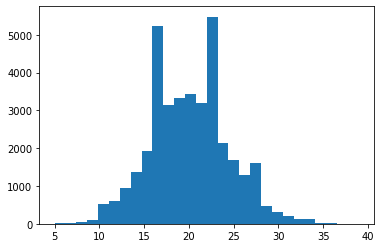

In [87]:
seg_dic = {x:0 for x in range(total_segments)}
for x in simplified_droplets:
    for ind in x[0]:
        seg_dic[ind] += 1

plt.hist(seg_dic.values(), bins=28)
print(min(seg_dic.values()),max(seg_dic.values()))

In [11]:
# nr_solves = []
# for i in range(len(simplified_droplets)):
#     output_data = {}
#     input_data = simplified_droplets[0:i]
#     newsolves = 1
#     while newsolves > 0:
#         input_data, output_data, newsolves = util.Decode(input_data, output_data)
#     nr_solves.append(len(output_data))

In [12]:
# x=range(len(simplified_droplets))
# plt.plot(x, nr_solves)

In [32]:
count=0
ind_unsolved = []
for x in input_data:
    for ind in x[0]:
        if ind not in ind_unsolved:
            ind_unsolved.append(ind)

ind_unsolved.sort()
    

In [33]:
ind_unsolved

[]